In [ ]:
# All Imports

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, BatchNormalization, 
    Conv2D, MaxPooling2D, GlobalAveragePooling2D)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import *

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score

from numba import cuda
import os, random, copy, warnings, math, time, csv
from pathlib import Path
from contextlib import redirect_stdout

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# paths
arr_dir = '/home/SharedFiles/Projects/EEG/Inputs/seq_arr/'
outputs_dir = '/home/SharedFiles/Projects/EEG/Outputs/runs'

In [16]:
### SETTINGS ###
model_name = 'CNN1D'
learning_rate = 1e-5
batch_size = 32 # 16 recommended
#num_classes = 2 # binary classification
epochs = 10#**2 # CHECKER
patience = 3 
scaler = MinMaxScaler()

# Dataset settings
train_ratio = 0.7

In [ ]:
def fetcher(_dir):
    patients, all_preictals, all_interictals = [], [], []
    for patient in os.listdir(_dir):
        if patient.startswith('SNUCH'):
            # if patient != 'SNUCH08':# 'SNUCH02' or patient == 'SNUCH03' or patient == 'SNUCH04' or patient == 'SNUCH05' or patient == 'SNUCH06' or patient == 'SNUCH07': # or patient == 'SNUCH08': 
            patient_pth = os.path.join(_dir, patient)
            patients.append(patient)
            all_preictals.append([])
            all_interictals.append([])
            for ictalType in os.listdir(patient_pth):
                ictalType_pth = os.path.join(patient_pth, ictalType) 
                if os.path.isdir(ictalType_pth):
                    if ictalType == 'preictals':
                        for preictal in os.listdir(ictalType_pth):
                            if not preictal.startswith('.'):
                                preictal_pth = os.path.join(ictalType_pth, preictal)
                                all_preictals[-1].append(preictal_pth)
                    if ictalType == 'interictals':
                        for interictal in os.listdir(ictalType_pth):
                            if not interictal.startswith('.'):
                                interictal_pth = os.path.join(ictalType_pth, interictal)
                                all_interictals[-1].append(interictal_pth)

    print('Num patients:', len(patients))
    print('Cnt equivalency:', len(patients) == len(all_preictals) == len(all_interictals))
    return patients, all_preictals, all_interictals

In [ ]:
# train valid test split
def split_data(preictals, interictals, train_ratio):
    X = [np.load(arr) for arr in preictals] + [np.load(arr) for arr in interictals]
    y = [1. for ele in preictals] + [0. for ele in interictals]
    
    data = list(zip(X, y))
    random.shuffle(data)
    
    train_size = int(len(data) * train_ratio)
    valid_size = int((len(data) - train_size) / 2) # 1:1 = valid:test
    valid_ind = train_size + valid_size
    
    train = data[:train_size]
    valid = data[train_size:valid_ind]
    test = data[valid_ind:]
    
    X_train, y_train = zip(*train)
    X_valid, y_valid = zip(*valid)
    X_test, y_test = zip(*test)
    
    return np.array(X_train, dtype=np.float32), np.array(y_train), np.array(X_valid, dtype=np.float32), np.array(y_valid), np.array(X_test, dtype=np.float32), np.array(y_test)

In [ ]:
class PerformanceVisualizationCallback(Callback):
    def __init__(self, model, validation_data, image_dir):
        super().__init__()
        self.model = model
        self.validation_data = validation_data
        
        os.makedirs(image_dir, exist_ok=True)
        self.image_dir = image_dir

    def on_epoch_end(self, epoch, logs={}):
        y_pred = np.asarray(self.model.predict(self.validation_data[0]))
        y_true = self.validation_data[1]             
        y_pred_class = np.argmax(y_pred, axis=1)

        # plot and save confusion matrix
        fig, ax = plt.subplots(figsize=(16,12))
        plot_confusion_matrix(y_true, y_pred_class, ax=ax)
        plt.show()
        #fig.savefig(os.path.join(self.image_dir, f'confusion_matrix_epoch_{epoch}'))

       # plot and save roc curve
        fig, ax = plt.subplots(figsize=(16,12))
        plot_roc(y_true, y_pred, ax=ax)
        plt.show()
        #fig.savefig(os.path.join(self.image_dir, f'roc_curve_epoch_{epoch}'))

In [ ]:
# def get_compiled_model():
#     model = Sequential()
#     model.add(Conv2D(16, 
#                      kernel_size=kernel_size,
#                      activation='relu',
#                      input_shape=input_shape))
#     model.add(Conv2D(32, kernel_size, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
#     model.add(Flatten())
#     model.add(Dense(32, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(num_classes, activation='softmax'))

#     model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
#                   loss=tf.keras.losses.binary_crossentropy,
#                   metrics=['accuracy'],
#                  )
#     return model

In [40]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, BatchNormalization, 
    Conv1D, MaxPooling1D, GlobalAveragePooling1D)


def cnn1d(batch_size, learning_rate, input_shape):
    print('Initiated CNN1D.py...')
    ## Setting
    model_name = 'CNN1D'
    new_input_shape = input_shape[:2]
    print('new input_shape:', new_input_shape)
    #kernel_size = (3)


    ## Model Construction
    model = Sequential()
    #C1
    model.add(Conv1D(filters=16, kernel_size=2, padding='valid', activation='relu', input_shape=new_input_shape))
    model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))
    model.add(BatchNormalization())

    #C2
    model.add(Conv1D(filters=32, kernel_size=2, padding='valid', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))
    model.add(BatchNormalization())

    #C3
    model.add(Conv1D(filters=64, kernel_size=2, padding='valid', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid')) 
    # use 1,sigmoid (instead of 2,softmax) for binary classification

    opt_adam = tf.keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(loss='binary_crossentropy', 
                  optimizer=opt_adam, 
                  metrics=['binary_accuracy'],
                 )

    return model

In [41]:
# #def cnn2d(batch_size, learning_rate, input_shape):
#     model = Sequential()
#     #C1
#     model.add(Conv2D(batch_size*2**0, kernel_size, padding='valid', activation='relu', input_shape=input_shape))
#     model.add(MaxPooling2D(pool_size=(2, 2),  padding='same'))
#     model.add(BatchNormalization())
    
#     #C2
#     model.add(Conv2D(batch_size*2**1, kernel_size, padding='valid', activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(BatchNormalization())
    
#     #C3
#     model.add(Conv2D(batch_size*2**2, kernel_size, padding='valid', activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(BatchNormalization())
    
#     model.add(Flatten())
#     model.add(Dropout(0.25))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(1, activation='sigmoid')) 
#     # use 1,sigmoid (instead of 2,softmax) for binary classification

#     opt_adam = tf.keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
#     model.compile(loss='binary_crossentropy', 
#                   optimizer=opt_adam, 
#                   metrics=['binary_accuracy'],
#                  )
    
#     return model

#### Why sigmoid over softmax for binary classification:
* https://ecwuuuuu.com/post/sigmoid-softmax-binary-class/
* https://medium.com/arteos-ai/the-differences-between-sigmoid-and-softmax-activation-function-12adee8cf322
* https://www.quora.com/Why-is-it-better-to-use-Softmax-function-than-sigmoid-function

# Model

In [42]:
# How to save output cell:
# https://ipython.readthedocs.io/en/stable/interactive/magics.html#cellmagic-capture

In [51]:
def modeler(arr_name, patients, all_preictals, all_interictals, t, cw, run_name, run_dir):
    # paths
    image_dir = os.path.join(run_dir, 'visuals')
    model_dir = os.path.join(run_dir, 'models')
    
    # Multi-GPU Set-up # https://keras.io/guides/distributed_training/
    strategy = tf.distribute.MirroredStrategy() # multi-GPU
    print('Num devices: {}'.format(strategy.num_replicas_in_sync)) # num GPUs
    print('Patience:', patience)
    print('Learning rate:', learning_rate)
    print('Batch size:', batch_size)
    
    print()
    print('-' * 65)
    
    # all auc plot
    plt.figure(4)
    plt.title('Model AUC (All Patients)')
    plt.axis([0,1,0,1])
    plt.ylabel('TPR')
    plt.xlabel('FPR')

    all_auc_keras, all_loss, all_acc = [], [], []
    
    for idx, patient in enumerate(patients[:2]): #### CHECKER
        #try:
        X_train, y_train, X_valid, y_valid, X_test, y_test = split_data(
            all_preictals[idx], all_interictals[idx], train_ratio)

        print('_' * 65)
        print(patient)
        print('=' * 65)
        print('Num total sequences:', len(all_preictals[idx]) + len(all_interictals[idx]))

        # print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

        # Scaling (for 3D shaped X)
        X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
        X_valid = scaler.transform(X_valid.reshape(-1, X_valid.shape[-1])).reshape(X_valid.shape)
        X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

        rows, cols = X_train.shape[1], X_train.shape[2]
        #input_shape = (rows, cols, 1) # for cnn2d
        input_shape = (rows, cols) # for cnn1d

        # 성형
        if model_name == 'CNN2D':
            X_train = X_train.reshape(X_train.shape[0], rows, cols, 1).astype('float32')
            X_valid = X_valid.reshape(X_valid.shape[0], rows, cols, 1).astype('float32')
            X_test = X_test.reshape(X_test.shape[0], rows, cols, 1).astype('float32')
        
        if model_name == 'CNN1D':           
            for data in (X_train, X_valid, X_test):
                data.reshape(data.shape[0], rows, cols).astype('float32')
                tf.reshape(data, [rows, cols])

        # y_train = to_categorical(y_train, num_classes) 
        # y_valid = to_categorical(y_valid, num_classes)
        # y_test = to_categorical(y_test, num_classes)

        # print(X_train.shape, y_train.shape,X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

        # Settings
        with strategy.scope(): # multi-gpu
            model = cnn1d(batch_size, learning_rate, input_shape) # CHECKER

        if idx == 0:
            model.summary()
            with redirect_stdout(t):
                model.summary()

        fname = '{}_{}_{}'.format(model_name, patient, arr_name)
        fpath = os.path.join(run_dir, 'models', fname)
        early_stopping_monitor = EarlyStopping(
            monitor='loss',
            patience=patience,
            restore_best_weights=True,
        )

        model_checkpoint_monitor = ModelCheckpoint(
            fpath, monitor='loss', verbose=0, 
            save_best_only=True, save_weights_only=True, 
            mode='auto', period=1,
        )

        performance_cbk = PerformanceVisualizationCallback(
              model=model,
              validation_data=(X_valid, y_valid),
              image_dir=image_dir,
        )

        # Fit model
        hist = model.fit(X_train, y_train, 
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(X_valid, y_valid),
              callbacks = [early_stopping_monitor, model_checkpoint_monitor],# performance_cbk]
        )

        val_loss, val_acc = model.evaluate(X_valid, y_valid, verbose=1)
        best_val_acc = max(hist.history['val_binary_accuracy'])
        best_val_loss = min(hist.history['val_loss'])
        all_loss.append(val_loss)
        all_acc.append(val_acc)

        print('Valid loss:', round(val_loss, 4), '|', 
              'Valid accuracy:', round(val_acc,4))
        print('Best valid loss:', round(best_val_loss,4), '|',
              'Best valid accuracy:', round(best_val_acc,4))
        # accuracy is binary accuracy

        # Check
        y_pred = model.predict(X_test).ravel()

        nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_pred)
        auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
        all_auc_keras.append(auc_keras)
        auc_score = roc_auc_score(y_test,y_pred)
        print('AUC Score:', round(auc_score,4))

        # Outputs
        curr_scores = [patient, round(auc_score,4), round(val_acc,4), round(val_loss,4)]
        #cw.writerow(curr_scores)

        # Visualization
        plt.figure(1)
        plt.plot(hist.history['loss'])
        plt.plot(hist.history['val_loss'])
        plt.gca().set_ylim([0,1])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Valid'], loc='upper left')
        fname = patient + '_loss_' + run_name + arr_name + '.png'
        fpath = os.path.join(image_dir, fname)
        #plt.savefig(fpath)
        plt.clf()

        plt.figure(2)
        plt.plot(hist.history['binary_accuracy'])
        plt.plot(hist.history['val_binary_accuracy'])
        plt.gca().set_ylim([0,1])
        plt.title('Model Accuracy')
        plt.ylabel('Binary Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Valid'], loc='upper left')
        fname = patient + '_acc_' + run_name + arr_name + '.png'
        fpath = os.path.join(image_dir, fname)
        #plt.savefig(fpath)
        plt.clf()

        plt.figure(3) 
        plt.title('Model AUC')
        plt.axis([0,1,0,1])
        plt.ylabel('TPR')
        plt.xlabel('FPR')
        plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='{}_{} (auc = {})'.format(model_name, arr_name, round(auc_keras,4)) )
        fname = patient + '_auc_' + run_name + arr_name + '.png'
        fpath = os.path.join(image_dir, fname)
        #plt.savefig(fpath)
        plt.clf()

        plt.figure(4) # all patients
        plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='{} (auc = {})'.format(patient, round(auc_keras,4)) )

        print()

        # Save
        #model.save(os.path.join(model_dir, patient))

        # Clear mem
        tf.keras.backend.clear_session() # may not work
        del model

        # except ValueError:
        #     print('Error with {}, skipping...'.format(patient) )
        #     continue

    print('_' * 65)

    avg_auc_keras = np.mean(all_auc_keras)
    print("Avg. auc for all patients:", avg_auc_keras)
    avg_scores = ['Avg', round(avg_auc_keras,4), round(np.mean(all_acc),4), round(np.mean(all_loss),4)]
    cw.writerow(avg_scores)
    
    plt.figure(4) # all auc plot
    plt.legend(loc='best')
    fname = 'all_auc' + run_name + arr_name + '.png'
    fpath = os.path.join(image_dir, fname)
    plt.savefig(fpath)
    plt.clf()

_________________________________________________________________
Dataset: seg10m_seq30s

CNN1D_seg10m_seq30s_20220401_144621
Num patients: 11
Cnt equivalency: True
Num devices: 2
Patience: 3
Learning rate: 1e-05
Batch size: 32

-----------------------------------------------------------------
_________________________________________________________________
SNUCH01
Num total sequences: 9173


InvalidArgumentError: Input to reshape is a tensor with 404523000 values, but the requested shape has 63000 [Op:Reshape]

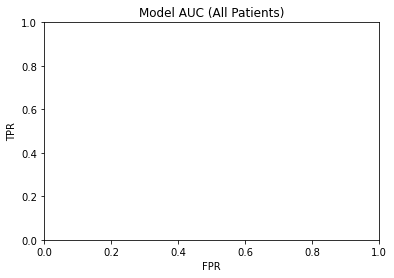

In [52]:
def main():
    #cuda.close()
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    
    for arr_name in os.listdir(arr_dir): 
        if not arr_name.startswith('.') and arr_name.startswith('seg10m'): #### CHECKER
            print('_' * 65)
            print('=' * 65)
            print('Dataset:', arr_name)
            print('=' * 65)
            print()
            
            run_name = model_name + '_' + arr_name + '_' + timestamp
            run_dir = os.path.join(outputs_dir, run_name)
            os.makedirs(run_dir, exist_ok=False)
            t = open(os.path.join(run_dir, 'model_run_' + run_name + '.txt'), 'w')
            c = open(os.path.join(run_dir, 'model_scores_' + run_name + 'csv'), 'w')
            cw = csv.writer(c)
            header = ['patient', 'auc', 'acc', 'loss']
            cw.writerow(header)
                     
            print(run_name)
            print(run_name, file=t)
            patients, all_preictals, all_interictals = fetcher(os.path.join(arr_dir, arr_name))
            #print(*map(len, [patients, all_preictals, all_interictals]))
            modeler(arr_name, patients, all_preictals, all_interictals, t, cw, run_name, run_dir)
            print('\n\n')
                                    
            t.close()
            c.close()
    
    # clear VRAM 
    #cuda.close()
    
    # cuda.select_device(0)
    # cuda.close()
    # cuda.select_device(1)
    # cuda.close()
main()